# Snowfall analysis

In [25]:
# Import librairies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
from prophet import Prophet

In [26]:
# Import df
df = pd.read_csv('donnees_meteo_148_stations.csv')

In [17]:
# Delete the closed ski station
stations_fermees = [
    "Alex", "Bozel", "Brison", "Burzier", "Cellier Valmorel", "Chamonix - les Pèlerins",
    "Col de Creusaz", "Col des Aravis", "Col du Champet", "Col du Chaussy", "Col du Frêne",
    "Col du Galibier", "Col du Plainpalais", "Col du Pré", "Col du Sommeiller", "Col du Tamié",
    "Crey Rond", "Doucy en Bauges", "Drouzin-Le-Mont", "Entremont", "Granier sur Aime",
    "Jarrier - La Tuvière", "La Sambuy", "Le Bouchet - Mont Charvin", "Le Cry - Salvagny",
    "Le Petit Bornand", "Les Bossons - Chamonix", "Marthod", "Molliessoulaz", "Montisel",
    "Notre Dame du pré", "Richebourg", "Saint Nicolas la Chapelle", "Saint-Jean de Sixt",
    "Sainte Foy", "Saxel", "Serraval", "Seytroux", "Sixt Fer à Cheval", "St-Pierre d'Entremont",
    "Termignon", "Thônes", "Thorens Glières", "Ugine", "Val Pelouse",
    "Verthemex - Mont du Chat", "Villards sur Thônes"
]

for station in stations_fermees:
    suppression = df[df["stations"].apply(lambda x: station in x)].index
    df = df.drop(suppression)

In [18]:
# Delete useless columns
df = df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y", "latitude", "longitude", "snowfall_water_equivalent_sum", "wind_speed_10m_mean", "soil_temperature_0_to_100cm_mean", "temperature_2m_max", "sunshine_duration","temperature_2m_mean", "cloud_cover_mean","rain_sum",
       "temperature_2m_min"], axis=1)

In [19]:
# Transform snowfall cm in meters
df.loc[:, "snowfall_sum"] = df["snowfall_sum"] / 100

### Per years

In [20]:
# Clean and rename
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df = df.rename(columns={'date': 'ds', 'snowfall_sum': 'y'})
df['ds'] = pd.to_datetime(df['ds'])

In [21]:
# Altitude
altitude_ranges = {
    "all": (None, None),
    "below_1000": (None, 1000),
    "1000_1300": (1000, 1300),
    "1300_1600": (1300, 1600),
    "above_1600": (1600, None),
}

10:20:45 - cmdstanpy - INFO - Chain [1] start processing
10:20:45 - cmdstanpy - INFO - Chain [1] done processing


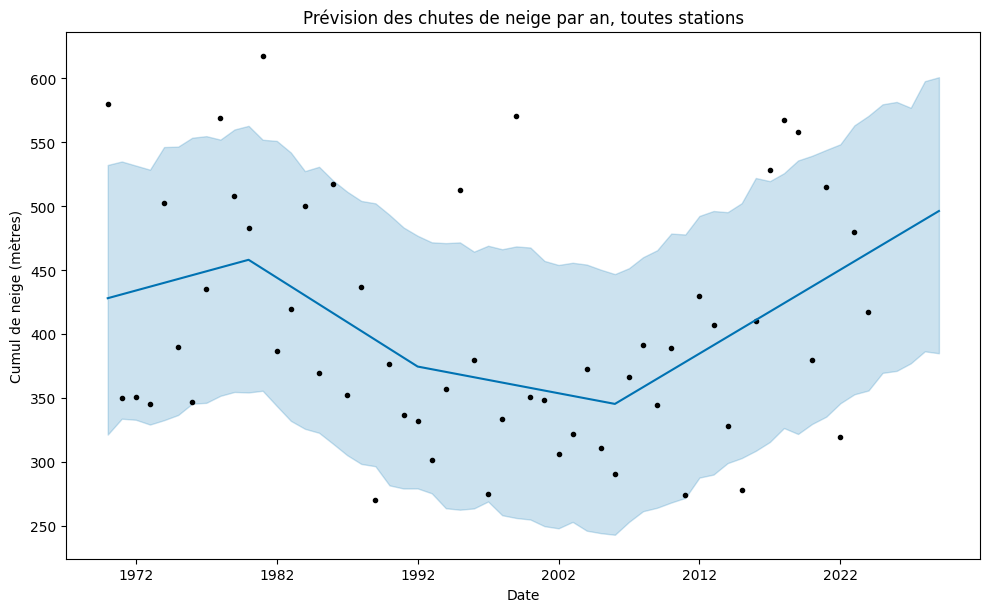

10:20:46 - cmdstanpy - INFO - Chain [1] start processing
10:20:46 - cmdstanpy - INFO - Chain [1] done processing


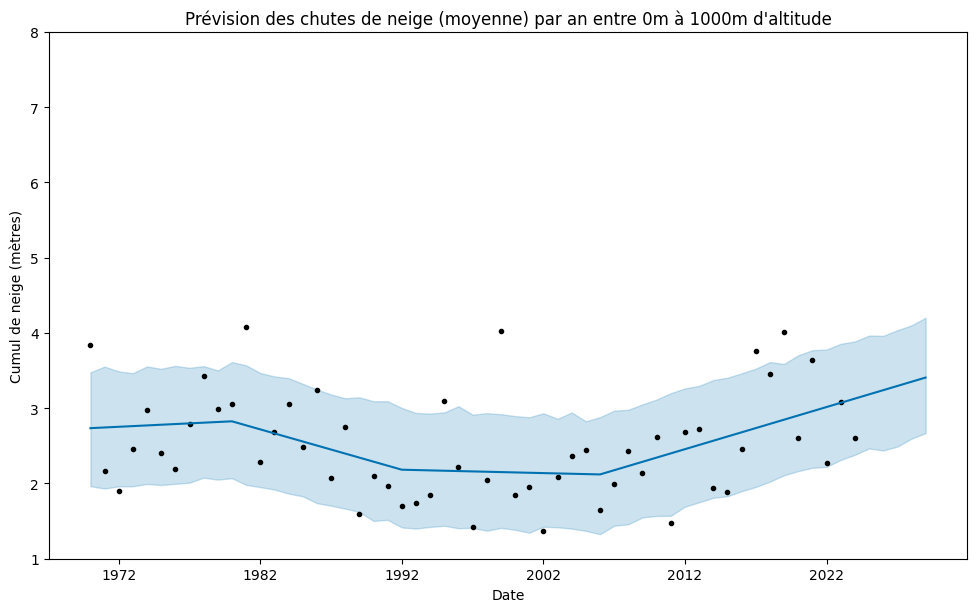

10:20:46 - cmdstanpy - INFO - Chain [1] start processing
10:20:47 - cmdstanpy - INFO - Chain [1] done processing


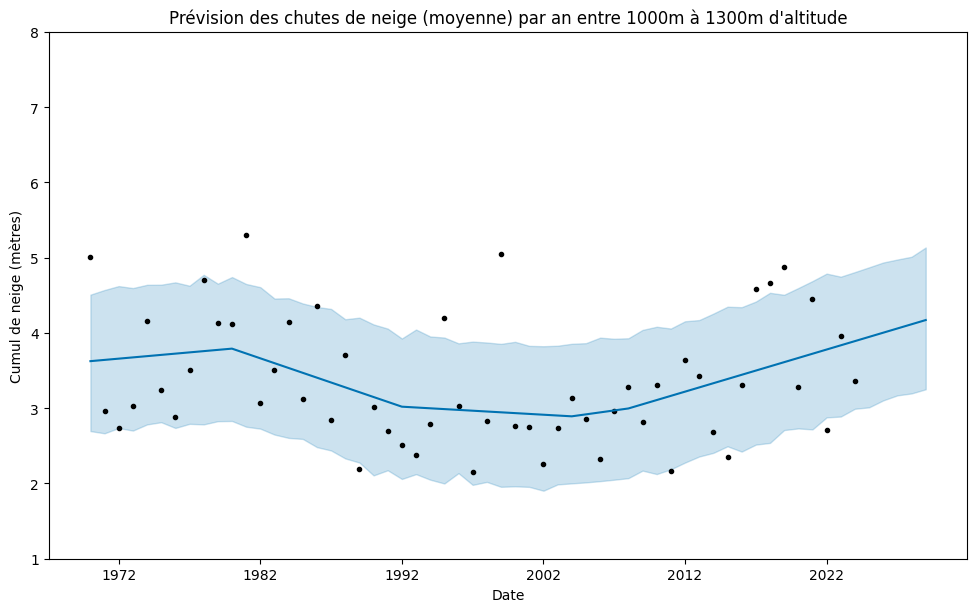

10:20:47 - cmdstanpy - INFO - Chain [1] start processing
10:20:48 - cmdstanpy - INFO - Chain [1] done processing


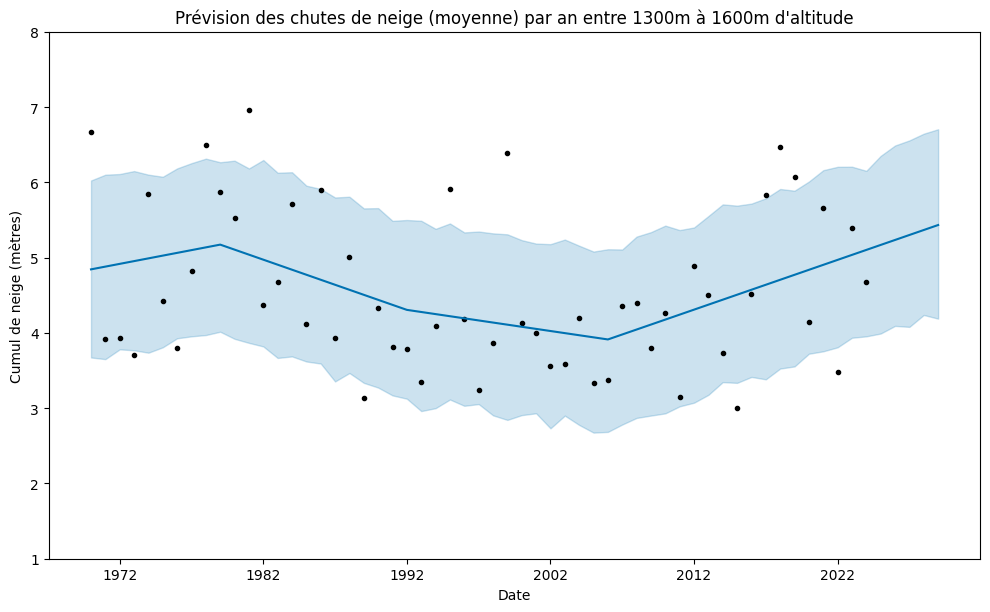

10:20:48 - cmdstanpy - INFO - Chain [1] start processing
10:20:48 - cmdstanpy - INFO - Chain [1] done processing


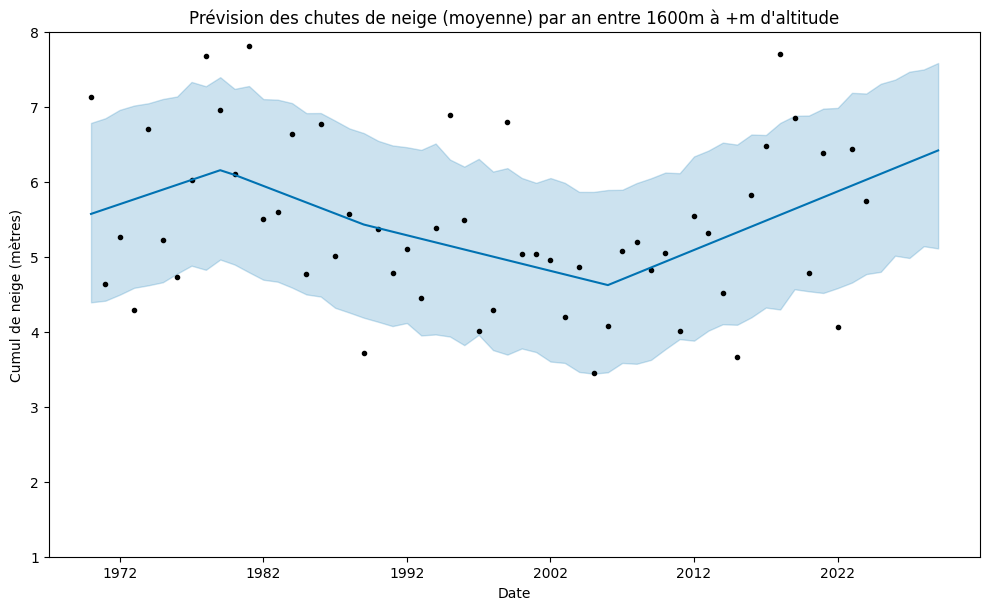

In [22]:
# Boucle
for label, (min_alt, max_alt) in altitude_ranges.items():
    df_filtered = df.copy()
    if min_alt is not None:
        df_filtered = df_filtered[df_filtered["altitude"] >= min_alt]
    if max_alt is not None:
        df_filtered = df_filtered[df_filtered["altitude"] < max_alt]
    
    df_filtered = df_filtered[df_filtered["ds"] < "2025-01-01"]

    df_annee = (
        df_filtered
        .set_index('ds')
        .resample('YS')
        .agg({
            'y': 'mean' if label != "all" else 'sum',
            'altitude': 'first'
        })
        .dropna()
        .reset_index()
    )

    if label != "all":
        df_annee['y'] = df_annee['y'] * 365  # conversion en cumul annuel

    # Prophet
    model = Prophet(
        yearly_seasonality=False,
        daily_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale=1,
        seasonality_prior_scale=10
    )

    df_train = df_annee[['ds', 'y']]
    model.fit(df_train)

    future = model.make_future_dataframe(periods=5, freq='YS')
    forecast = model.predict(future)

    # Plot
    model.plot(forecast)
    if label == "all":
        plt.title("Prévision des chutes de neige par an, toutes stations")
    else:
        range_str = f"{min_alt or 0}m à {max_alt or '+'}m"
        plt.title(f"Prévision des chutes de neige (moyenne) par an entre {range_str} d'altitude")
        plt.ylim(1, 8)
    plt.xlabel("Date")
    plt.ylabel("Cumul de neige (mètres)")
    plt.grid()
    plt.show()

## Prophet per station test for the streamlit

In [23]:
# Input
station_choisie = input("Entrez le nom de la station pour laquelle vous souhaitez afficher des prédictions : ")

10:22:27 - cmdstanpy - INFO - Chain [1] start processing
10:22:27 - cmdstanpy - INFO - Chain [1] done processing


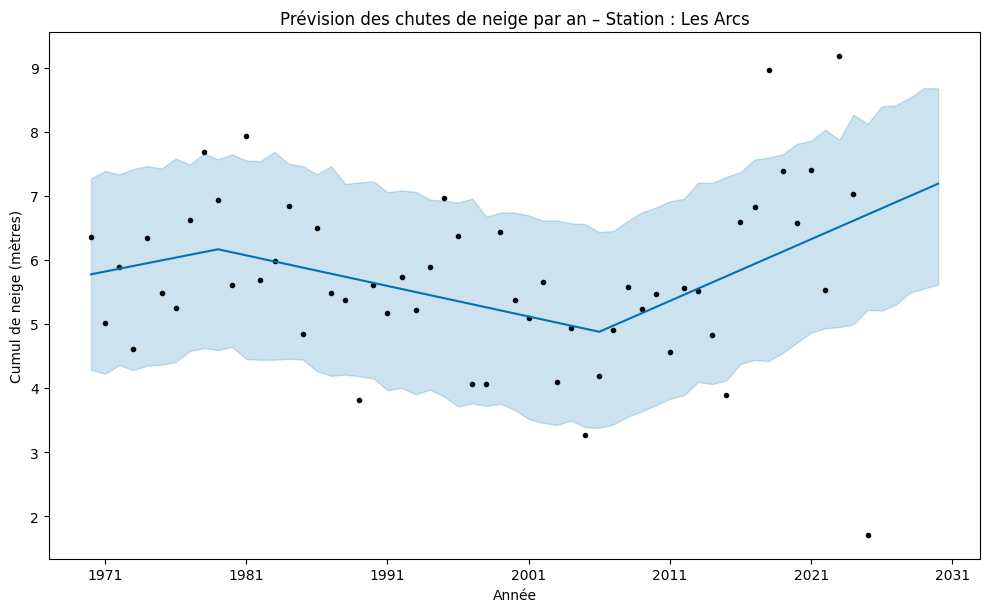

In [26]:
df_station = df[df['stations'] == station_choisie]

df_station_agg = (
    df_station
    .set_index('ds')
    .resample('YS')
    .agg({
        'y': 'sum',
        'altitude': 'first'
    })
    .dropna()
    .reset_index()
)

# Parameters
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=1, 
    seasonality_prior_scale=10   
)

model.fit(df_station_agg)

future = model.make_future_dataframe(periods=5, freq='YS')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title(f"Prévision des chutes de neige par an – Station : {station_choisie}")
plt.xlabel("Année")
plt.ylabel("Cumul de neige (mètres)")
plt.grid()
plt.show()

# Temperature Analysis

In [1]:
# Import librairies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
from prophet import Prophet

# Import the df
df = pd.read_csv('donnees_meteo_148_stations.csv')

# Delete the closed ski station
stations_fermees = [
    "Alex", "Bozel", "Brison", "Burzier", "Cellier Valmorel", "Chamonix - les Pèlerins",
    "Col de Creusaz", "Col des Aravis", "Col du Champet", "Col du Chaussy", "Col du Frêne",
    "Col du Galibier", "Col du Plainpalais", "Col du Pré", "Col du Sommeiller", "Col du Tamié",
    "Crey Rond", "Doucy en Bauges", "Drouzin-Le-Mont", "Entremont", "Granier sur Aime",
    "Jarrier - La Tuvière", "La Sambuy", "Le Bouchet - Mont Charvin", "Le Cry - Salvagny",
    "Le Petit Bornand", "Les Bossons - Chamonix", "Marthod", "Molliessoulaz", "Montisel",
    "Notre Dame du pré", "Richebourg", "Saint Nicolas la Chapelle", "Saint-Jean de Sixt",
    "Sainte Foy", "Saxel", "Serraval", "Seytroux", "Sixt Fer à Cheval", "St-Pierre d'Entremont",
    "Termignon", "Thônes", "Thorens Glières", "Ugine", "Val Pelouse",
    "Verthemex - Mont du Chat", "Villards sur Thônes"
]

for station in stations_fermees:
    suppression = df[df["stations"].apply(lambda x: station in x)].index
    df = df.drop(suppression)

# Delete useless columns
df = df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y", "latitude", "longitude", "snowfall_water_equivalent_sum","snowfall_sum", "wind_speed_10m_mean", "soil_temperature_0_to_100cm_mean", "temperature_2m_max", "sunshine_duration", "cloud_cover_mean","rain_sum",
       "temperature_2m_min"], axis=1)


c:\Users\ambri\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Convert datetime
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)

# Rename for Prophet
df = df.rename(columns={
    'date': 'ds',
    'temperature_2m_mean': 'y'
})


## Per years

10:56:02 - cmdstanpy - INFO - Chain [1] start processing
10:56:02 - cmdstanpy - INFO - Chain [1] done processing


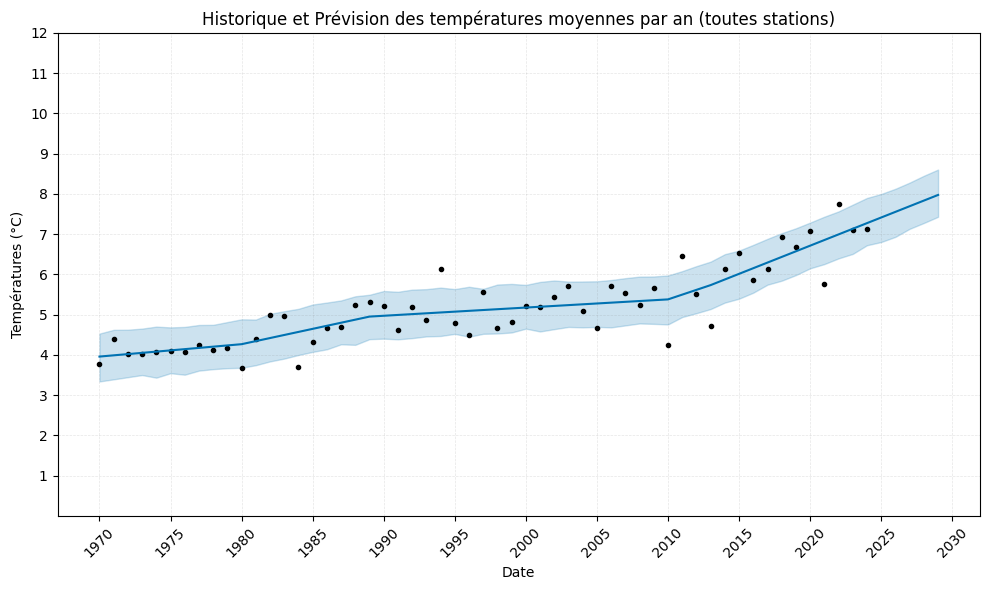

10:56:03 - cmdstanpy - INFO - Chain [1] start processing
10:56:03 - cmdstanpy - INFO - Chain [1] done processing


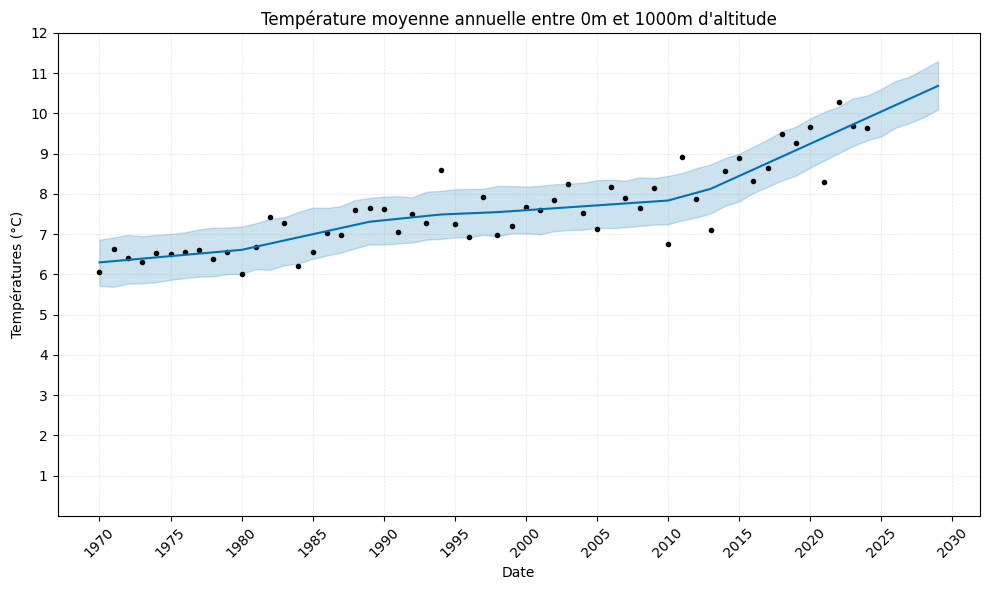

10:56:04 - cmdstanpy - INFO - Chain [1] start processing
10:56:04 - cmdstanpy - INFO - Chain [1] done processing


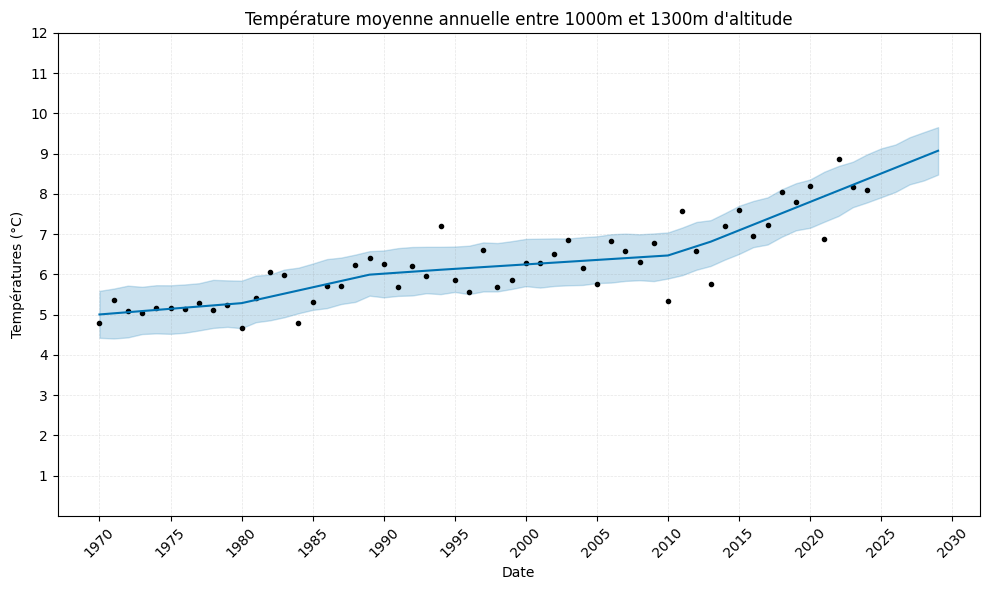

10:56:05 - cmdstanpy - INFO - Chain [1] start processing
10:56:05 - cmdstanpy - INFO - Chain [1] done processing


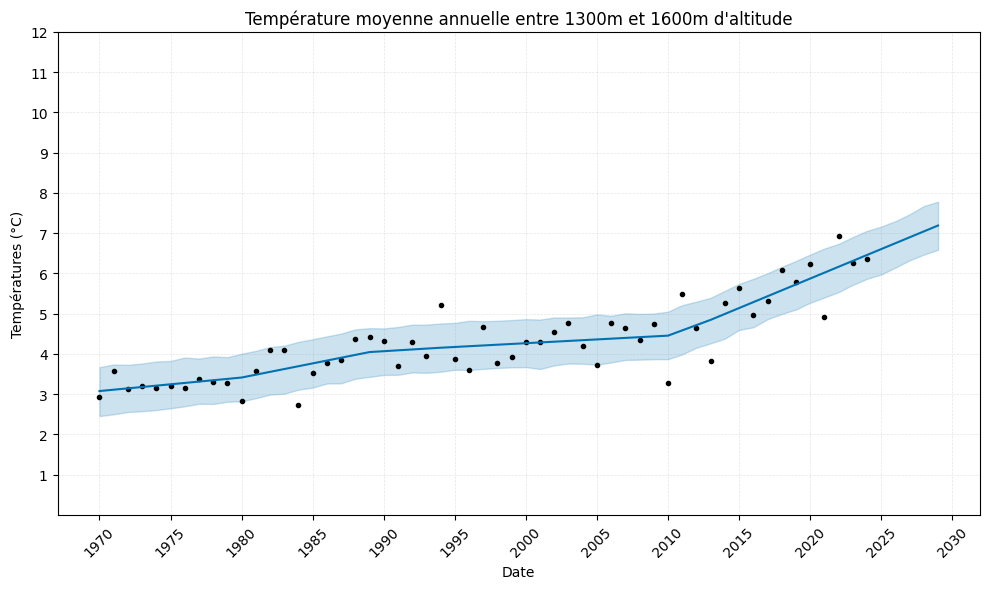

10:56:06 - cmdstanpy - INFO - Chain [1] start processing
10:56:06 - cmdstanpy - INFO - Chain [1] done processing


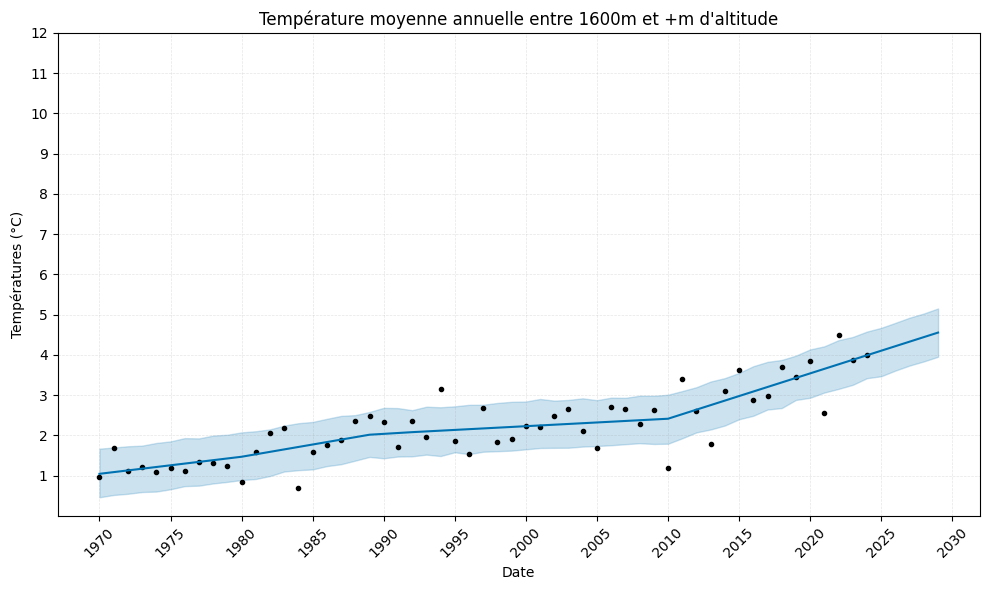

In [3]:
# Altitude
altitude_ranges = {
    "all": (None, None),
    "below_1000": (None, 1000),
    "1000_1300": (1000, 1300),
    "1300_1600": (1300, 1600),
    "above_1600": (1600, None),
}
for label, (min_alt, max_alt) in altitude_ranges.items():
    df_filtered = df.copy()

    # Filtrage altitude
    if min_alt is not None:
        df_filtered = df_filtered[df_filtered["altitude"] >= min_alt]
    if max_alt is not None:
        df_filtered = df_filtered[df_filtered["altitude"] < max_alt]

    # Filtrage date
    df_filtered = df_filtered[df_filtered["ds"] < "2025-01-01"]

    # Agrégation annuelle
    df_agg = (
        df_filtered
        .set_index('ds')
        .resample('YS')
        .agg({
            'y': 'mean',
            'altitude': 'first'
        })
        .dropna()
        .reset_index()
    )

    # Prophet
    model = Prophet(
        yearly_seasonality=False,
        daily_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale=1,
        seasonality_prior_scale=10
    )

    df_train = df_agg[['ds', 'y']]
    model.fit(df_train)

    future = model.make_future_dataframe(periods=5, freq='YS')
    forecast = model.predict(future)

    # Plot
    fig = model.plot(forecast)
    plt.ylim(0, 12)
    plt.yticks(range(1, 13))
    
    # Titre dynamique selon catégorie
    if label == "all":
        plt.title("Historique et Prévision des températures moyennes par an (toutes stations)")
    else:
        min_txt = f"{min_alt:.0f}" if min_alt is not None else "0"
        max_txt = f"{max_alt:.0f}" if max_alt is not None else "+"
        plt.title(f"Température moyenne annuelle entre {min_txt}m et {max_txt}m d'altitude")

    # Axes
    plt.xlabel("Date")
    plt.ylabel("Températures (°C)")
    locator = mdates.YearLocator(5)
    formatter = mdates.DateFormatter('%Y')
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


## Prophet per station test for the streamlit

10:56:20 - cmdstanpy - INFO - Chain [1] start processing


Station choisie : Les Arcs


10:56:20 - cmdstanpy - INFO - Chain [1] done processing


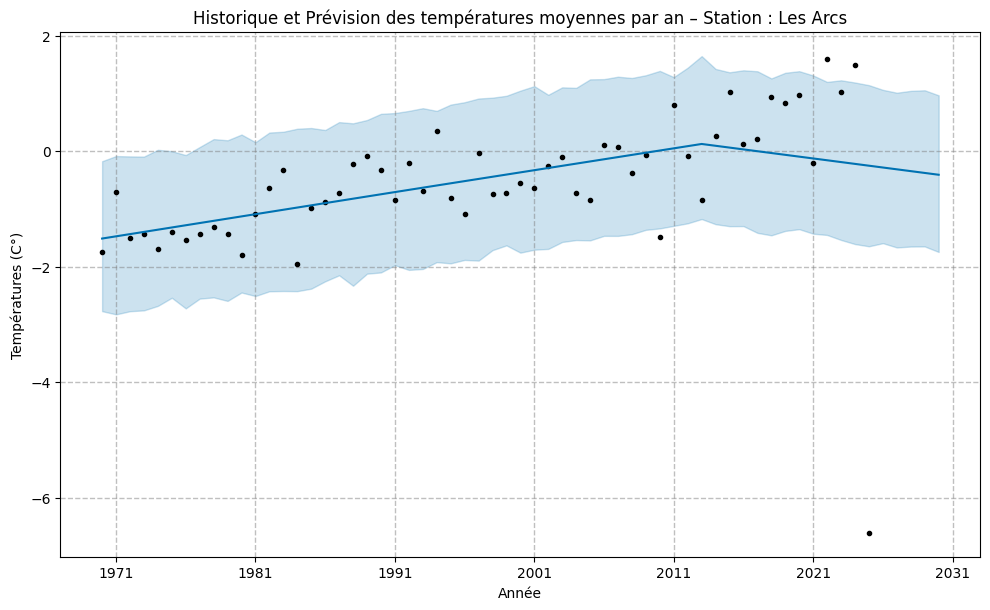

In [4]:
station_choisie = input("Entrez le nom de la station pour laquelle vous souhaitez afficher des prédictions : ")
print(f"Station choisie : {station_choisie}")
df_station = df[df['stations'] == station_choisie]

df_station_agg = (
    df_station
    .set_index('ds')
    .resample('YS')
    .agg({
        'y': 'mean', 
        'altitude': 'first'
    })
    .reset_index()
)

# Parameters
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=1,     
    seasonality_prior_scale=10       
)


model.fit(df_station_agg)

future = model.make_future_dataframe(periods=5, freq='YS')

forecast = model.predict(future)

fig = model.plot(forecast)
plt.title(f"Historique et Prévision des températures moyennes par an – Station : {station_choisie}")
plt.xlabel("Année")
plt.ylabel("Températures (C°)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()